   PassengerId  Pclass                                               Name  \
0            1       3                            Braund, Mr. Owen Harris   
1            2       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3       3                             Heikkinen, Miss. Laina   
3            4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0    male  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  female  38.0      1      0          PC 17599  71.2833   C85        C  
2  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
3  female  35.0      1      0            113803  53.1000  C123        S  
4    male  35.0      0      0            373450   8.0500   NaN        S  


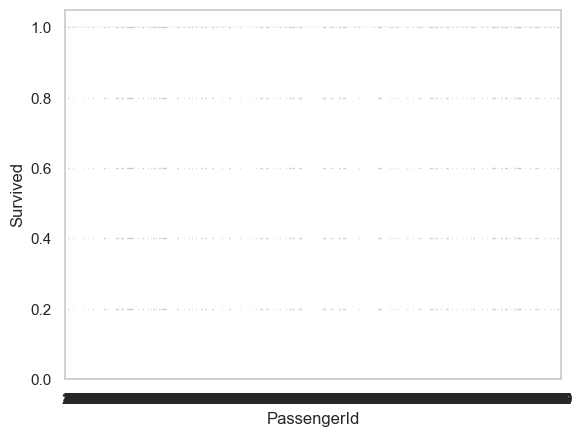

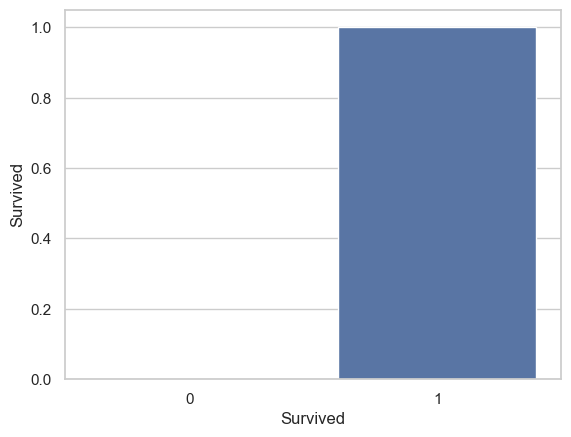

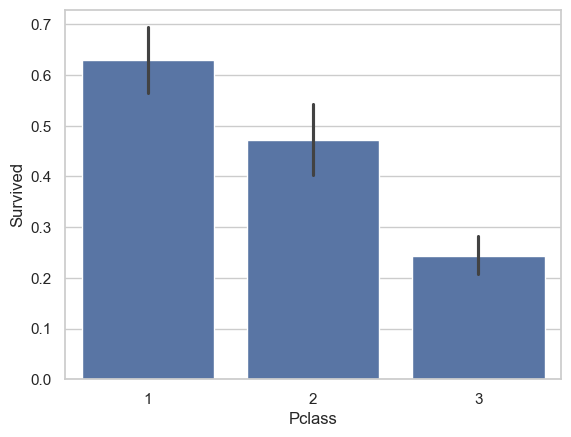

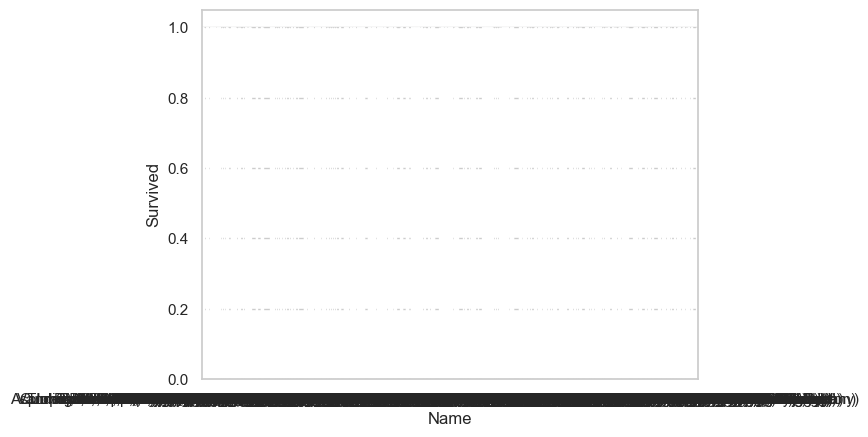

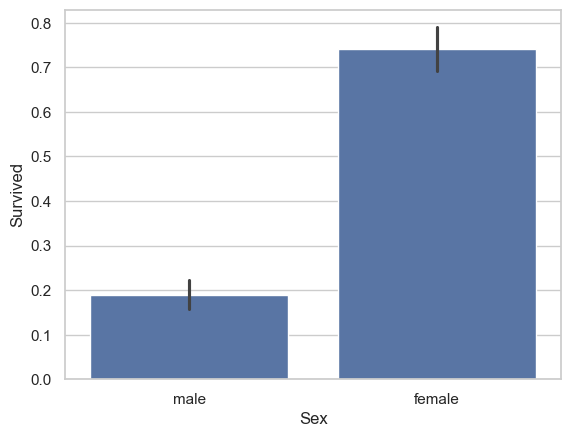

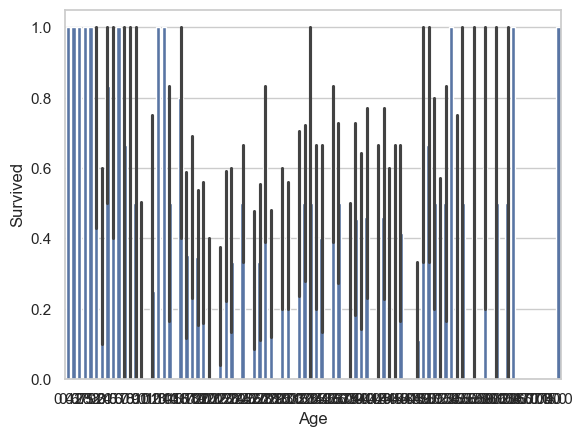

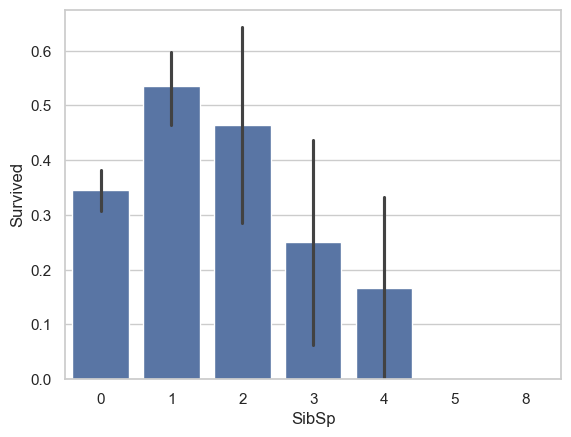

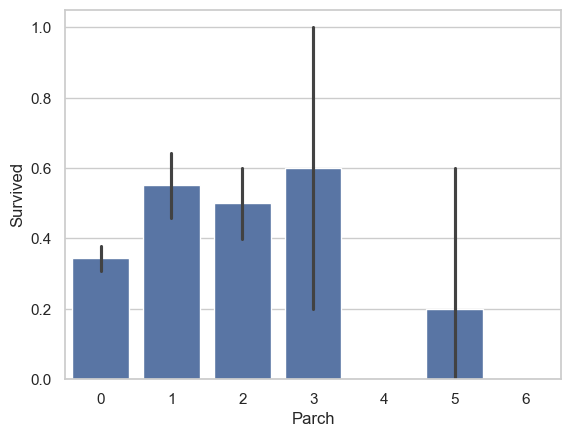

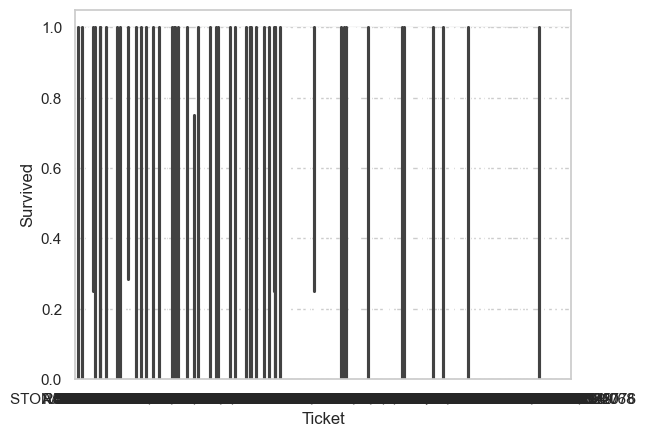

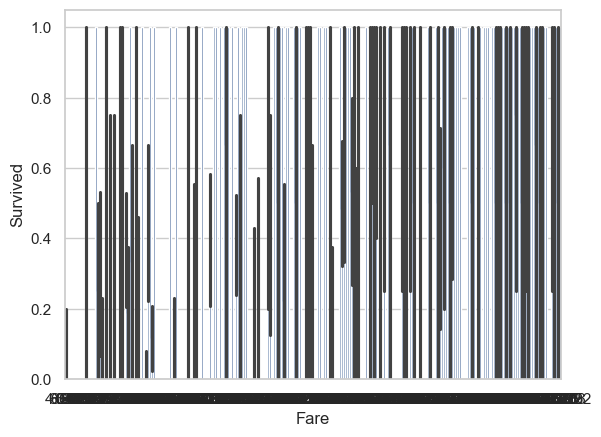

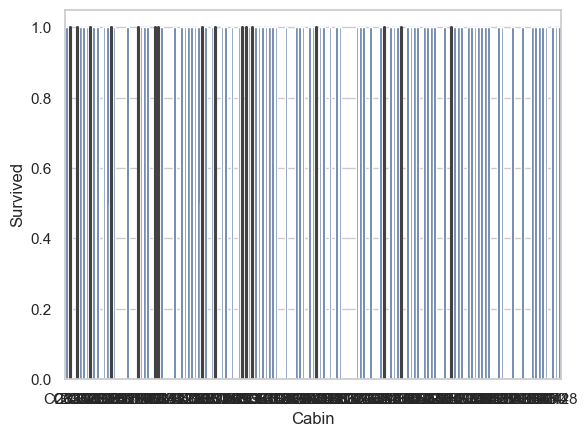

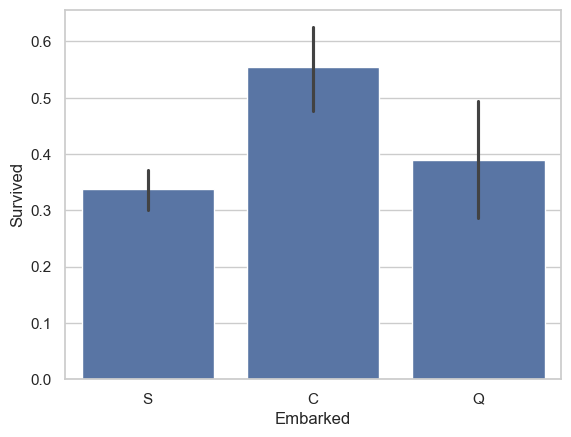

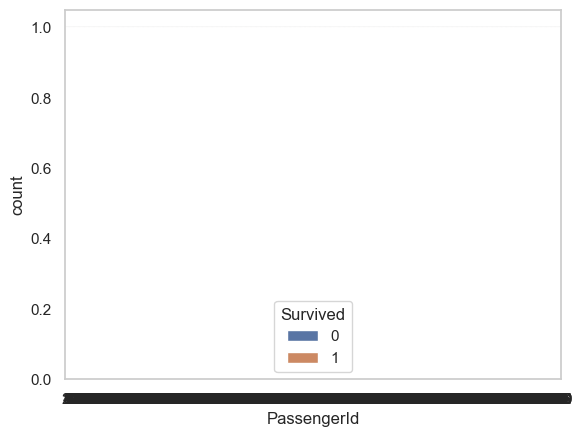

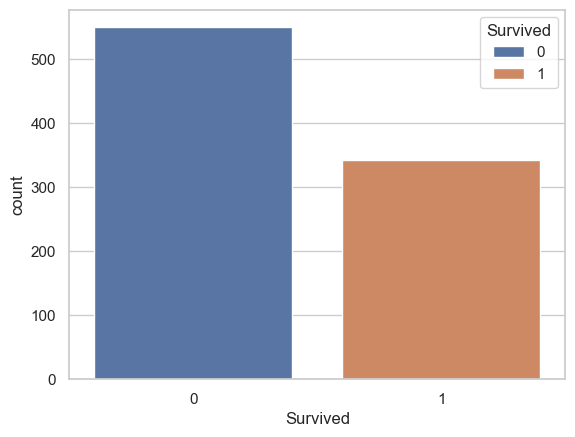

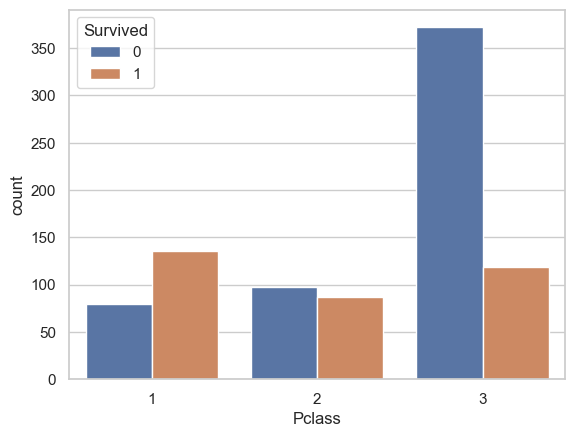

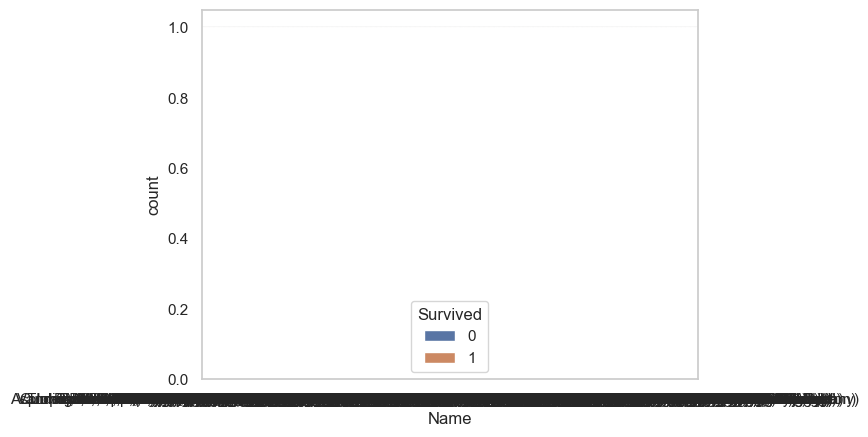

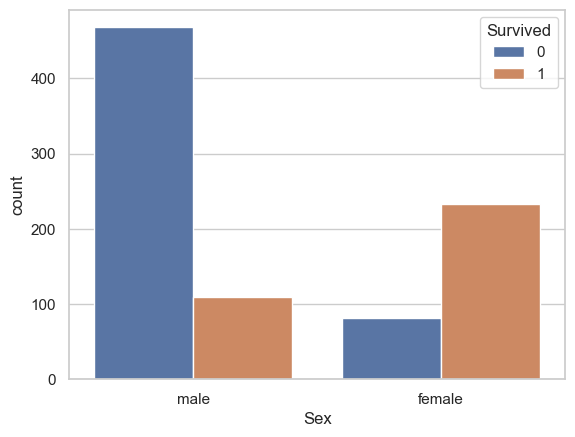

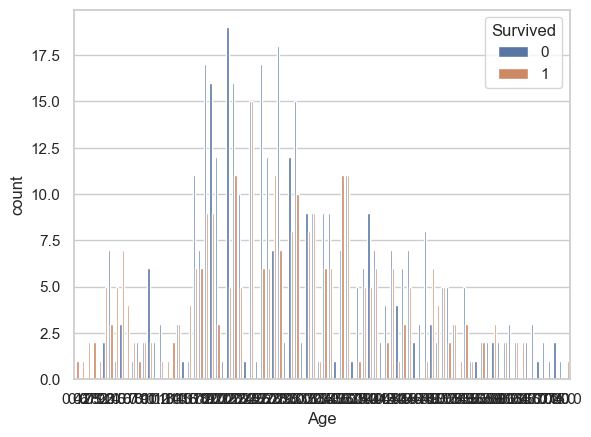

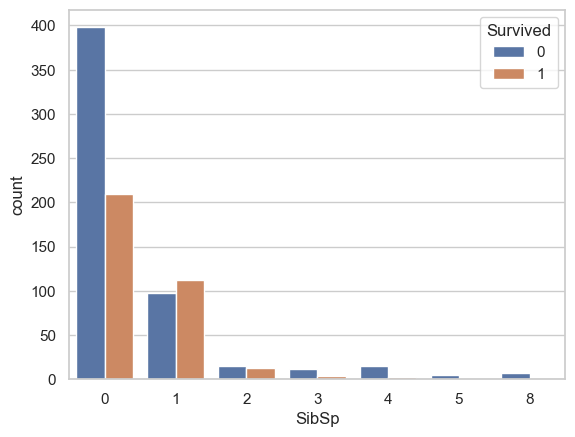

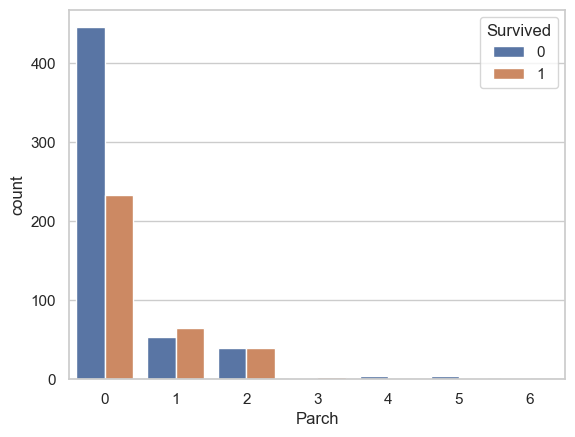

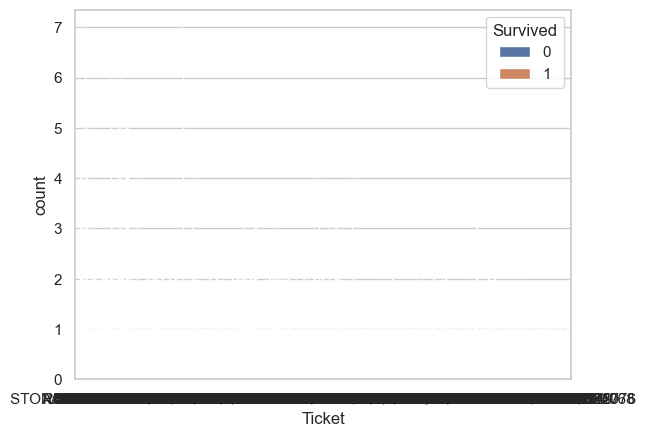

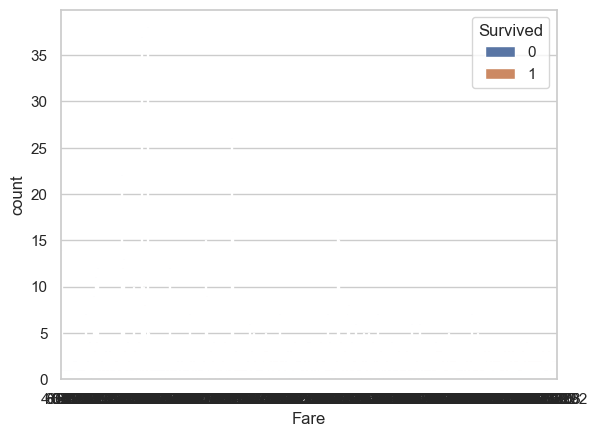

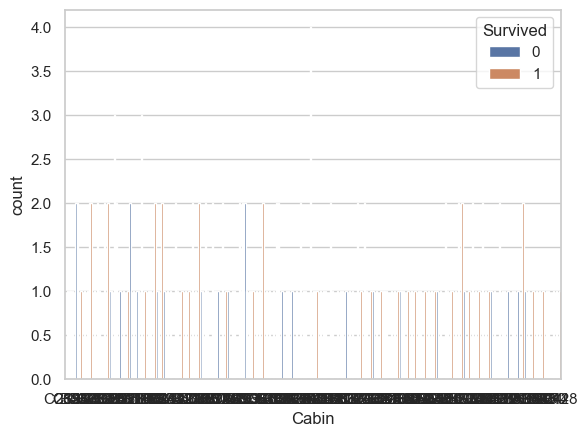

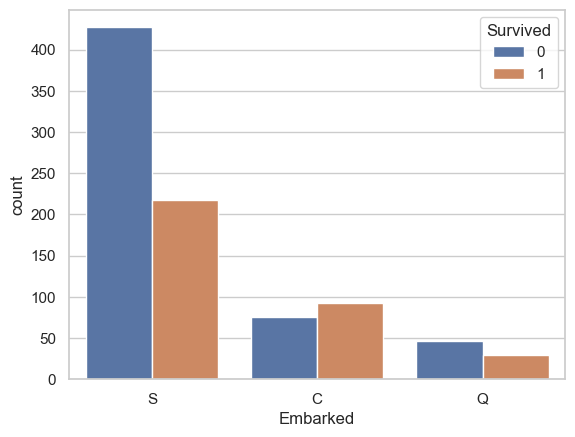

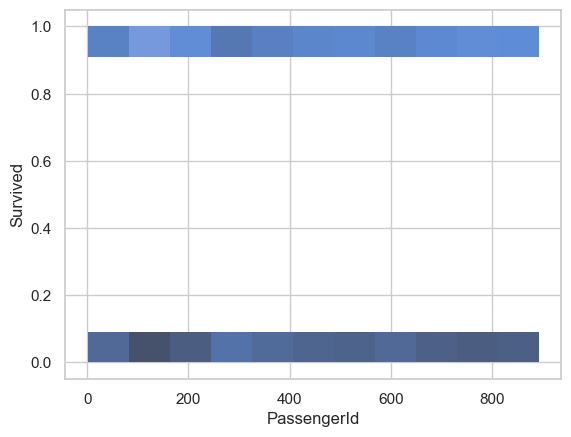

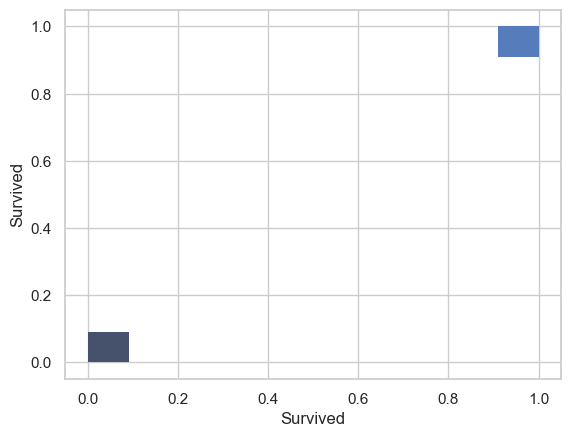

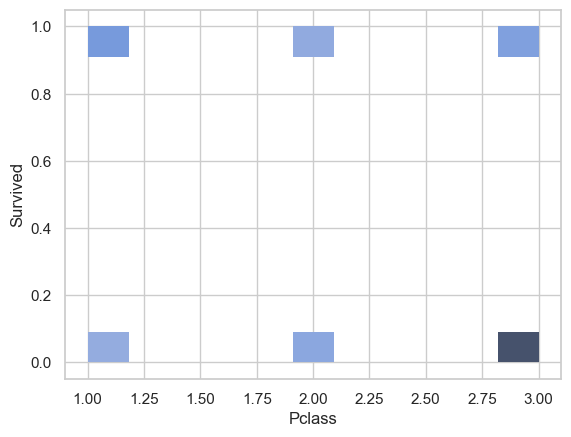

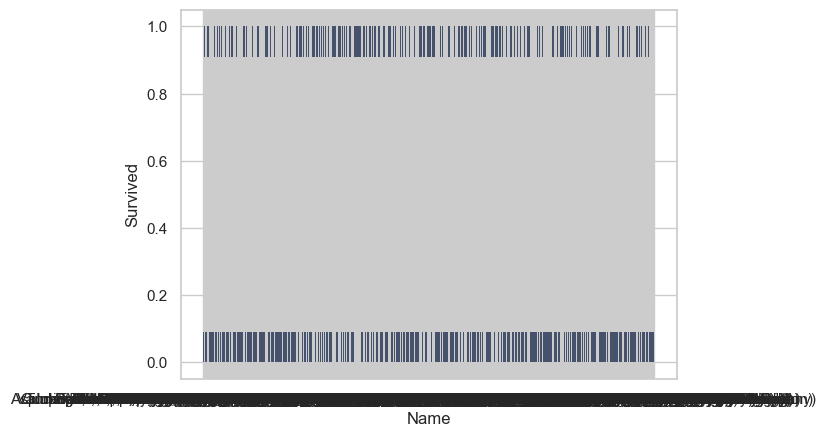

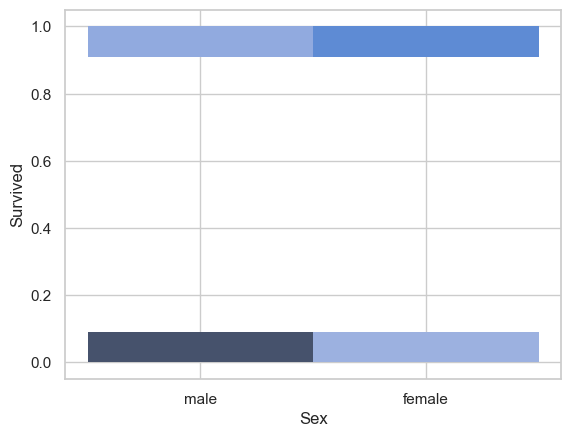

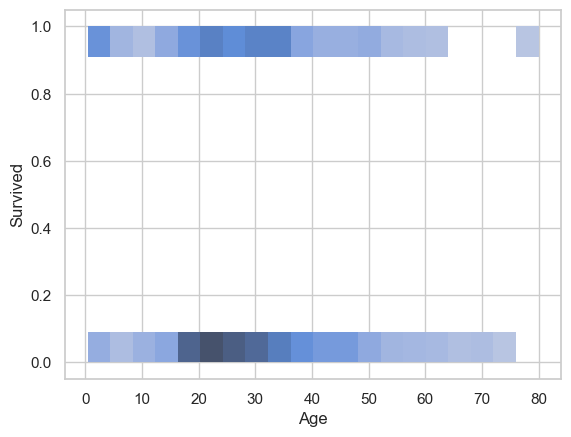

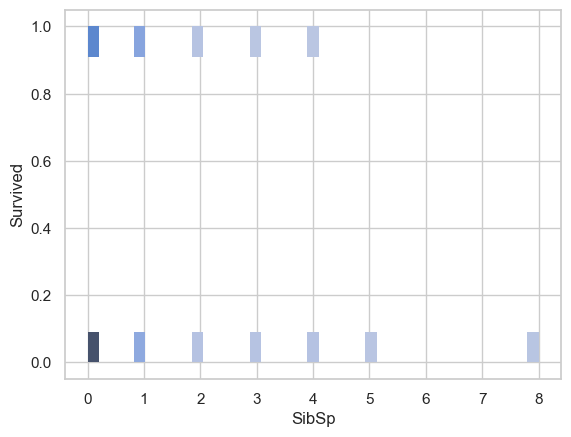

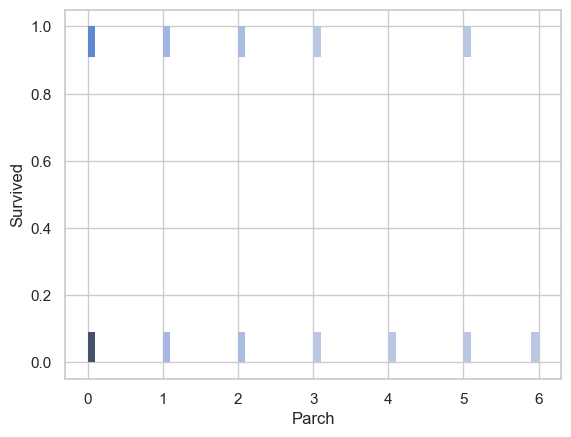

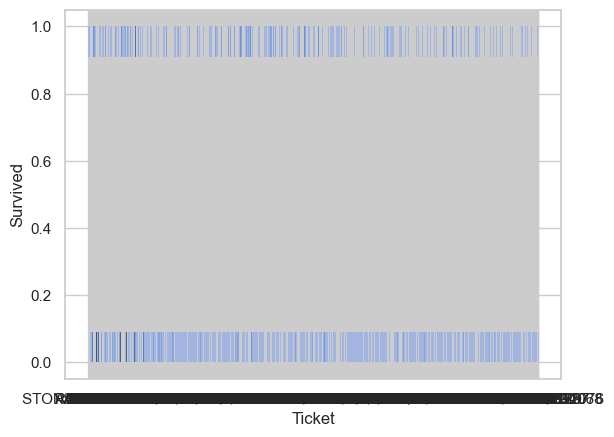

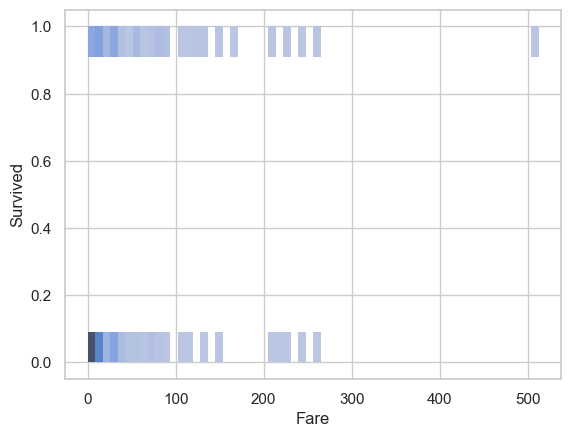

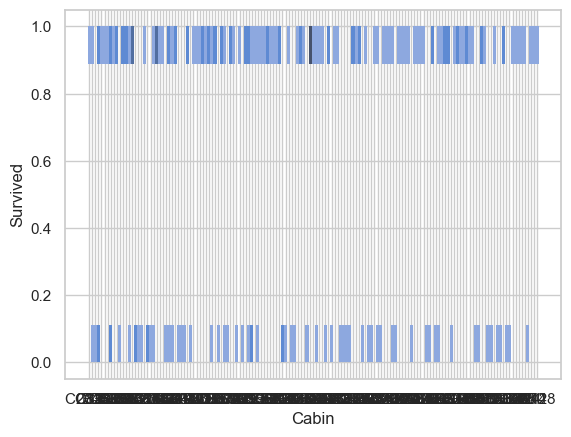

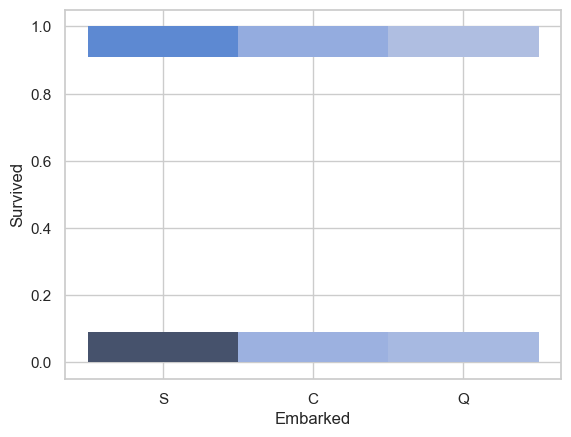

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
import pandas as pd
import pathlib as path
import matplotlib as plt
import seaborn as sns
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train, test = df.drop(columns=['Survived']), df.Survived
print(train.head())

for i in df.columns:
    sns.barplot(x=i, y='Survived', data=df)
    plt.pyplot.show()

for i in df.columns:
    sns.countplot(x=i, hue='Survived', data=df)
    plt.pyplot.show()

for i in df.columns:
    sns.histplot(x=i, y='Survived', data=df)
    plt.pyplot.show()

for i in df.columns:
    sns.heatmap(x=i, hue='Survived', data=df)
    plt.pyplot.show()

for i in df.columns:
    sns.boxplot(x=i, hue='Survived', data=df)
    plt.pyplot.show()

In [ ]:

# Visual Exploratory Data Analysis (starts here in cell 2)
# The cell is robust: if `df` is not present from cell 1, it will load the CSV itself.
try:
    df
except NameError:
    import pandas as pd
    from pathlib import Path
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    path = Path(r'C:\Users\user\Documents\GitHub\notebooks-on-ml\TITANIC\DATA\train.csv')
    df = pd.read_csv(path)
    print('Loaded dataset in cell 2 from', path)

# Small helper to show sections clearly
from IPython.display import display, Markdown

def section(title):
    display(Markdown('### ' + title))

# 1) Quick overview
section('Quick overview')
print('Shape:', df.shape)
print('\nColumns and dtypes:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isna().sum())

# 2) Categorical counts & survival rates
section('Categorical counts & survival rates')
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
plt.subplot(2,3,1)
sns.countplot(data=df, x='Survived')
plt.title('Count of Survival (0 = No, 1 = Yes)')

plt.subplot(2,3,2)
sns.barplot(x='Sex', y='Survived', data=df, ci=None)
plt.title('Survival Rate by Sex')

plt.subplot(2,3,3)
sns.barplot(x='Pclass', y='Survived', data=df, ci=None)
plt.title('Survival Rate by Pclass')

plt.subplot(2,3,4)
sns.countplot(data=df, x='Pclass')
plt.title('Count by Pclass')

plt.subplot(2,3,5)
# Some Embarked values may be NaN; keep dropna=False to show counts
sns.barplot(x='Embarked', y='Survived', data=df, ci=None)
plt.title('Survival Rate by Embarked')

plt.subplot(2,3,6)
sns.countplot(data=df, x='Embarked')
plt.title('Count by Embarked')

plt.tight_layout()
plt.show()

display(Markdown("**Interpretation:** Females generally have higher survival; higher classes (1) show higher survival rates. `Embarked` differences may reflect class composition."))

# 3) Numeric distributions: Age & Fare
section('Numeric distributions: Age & Fare')
plt.figure(figsize=(12,4))
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Age distribution (all passengers)')
plt.show()

plt.figure(figsize=(12,4))
sns.kdeplot(data=df, x='Age', hue='Survived', multiple='stack')
plt.title('Age distribution by Survival (stacked KDE)')
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(df['Fare'].dropna(), bins=40, kde=True)
plt.title('Fare distribution (right-skewed)')
plt.show()

display(Markdown("**Notes:** `Age` has missing values; `Fare` is right-skewed (log transform may help)."))

# 4) Distribution comparisons (box/violin)
section('Box & Violin comparisons')
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Age by Pclass')

plt.subplot(1,2,2)
sns.violinplot(x='Survived', y='Age', data=df)
plt.title('Age distribution by Survival')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df)
plt.title('Fare by Pclass and Survival')
plt.legend(title='Survived')
plt.show()

# 5) Correlation heatmap & pairplot (sampled)
section('Correlation & pairwise relationships')
num_cols = ['Survived','Pclass','Age','SibSp','Parch','Fare']
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (selected numeric columns)')
plt.show()

pair_sample = df[num_cols].dropna()
if len(pair_sample) > 400:
    pair_sample = pair_sample.sample(frac=0.4, random_state=1)

sns.pairplot(pair_sample, hue='Survived', diag_kind='kde', corner=True)
plt.suptitle('Pairplot (sampled) of numeric features', y=1.02)
plt.show()

# 6) Missingness and stacked proportions
section('Missingness and stacked proportions')
plt.figure(figsize=(10,3))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing values (True = NaN)')
plt.show()

ct = pd.crosstab(df['Pclass'], df['Survived'], normalize='index')
ax = ct.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Paired')
ax.set_ylabel('Proportion')
ax.set_title('Proportion Survived by Pclass (stacked)')
plt.legend(title='Survived')
plt.show()

# Final brief summary printed
section('Short summary')
print('- Top predictive signals visible: Sex, Pclass, Fare (and Age after imputation).')
print("- Next suggestions: impute Age, encode categorical vars, create title/party-size features, and try an initial classifier.")

print('\nDone: visualizations generated in cell 2.')